In [1]:
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import time
from time import sleep

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

def std(x): return np.std(x)

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            if str(col_type) == numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            if str(col_type)[:5] == 'float':
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [2]:
if True:
    df_train = pd.read_csv('../../dataset/train/train_converted.csv')
    df_test  = pd.read_csv('../../dataset/test/test_converted.csv')
    df_train = df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
    df_test = df_test[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()

else:

    df_train = pd.read_pickle('../../dataset/train/train_converted_fill.pkl')
    df_test  = pd.read_pickle('../../dataset/test/test_converted_fill.pkl')

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

Memory usage of dataframe is 107.97 MB
Memory usage after optimization is: 33.78 MB
Decreased by 68.7%
Memory usage of dataframe is 21.59 MB
Memory usage after optimization is: 4.08 MB
Decreased by 81.1%


In [3]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

In [4]:
df_train['ID'] = df_train['Z_MODELO'] + '|' + df_train['Z_PUNTO_VENTA'] + '|' + df_train['Z_GAMA']
df_test['ID'] = df_test['Z_MODELO'] + '|' + df_test['Z_PUNTO_VENTA'] + '|' + df_test['Z_GAMA']

base = df_train[['ID', 'Demanda', 'Z_WEEK_DATE']].groupby(['ID', 'Z_WEEK_DATE']).sum().sort_values('Demanda' , ascending = [False]).reset_index()
base_cum = df_train[['Demanda', 'Z_WEEK_DATE']].groupby([ 'Z_WEEK_DATE']).sum().sort_values('Demanda' , ascending = [False]).reset_index()

In [5]:
df_train.head(1)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK,Z_WEEK_DATE,Demanda,ID
0,MOD_1,PVENT_1,GAM_1,SEMANA_01,2021-05-17,0,MOD_1|PVENT_1|GAM_1


In [6]:
base = base.merge(base_cum[['Z_WEEK_DATE', 'Demanda']].rename(columns = {'Demanda': 'Demanda_Total'}), on = 'Z_WEEK_DATE', how = "left")

In [7]:
base

,ID,Z_WEEK_DATE,Demanda,Demanda_Total
0,MOD_3|PVENT_1|GAM_4,2021-07-19,1451,45037
1,MOD_3|PVENT_1|GAM_4,2021-07-12,1201,47069
2,MOD_27|PVENT_1|GAM_1,2021-06-07,1032,38374
3,MOD_3|PVENT_1|GAM_4,2021-06-21,1005,40481
4,MOD_2|PVENT_1|GAM_1,2021-12-06,934,43389
...,...,...,...,...
2358645,MOD_25|PVENT_409|GAM_1,2022-02-21,0,32408
2358646,MOD_25|PVENT_409|GAM_1,2022-02-14,0,33511
2358647,MOD_25|PVENT_409|GAM_1,2022-02-07,0,35144
2358648,MOD_25|PVENT_409|GAM_1,2022-01-31,0,32240


In [8]:
base['ratio'] = base['Demanda']*100/base['Demanda_Total']

In [9]:
base

,ID,Z_WEEK_DATE,Demanda,Demanda_Total,ratio
0,MOD_3|PVENT_1|GAM_4,2021-07-19,1451,45037,3.221795
1,MOD_3|PVENT_1|GAM_4,2021-07-12,1201,47069,2.551573
2,MOD_27|PVENT_1|GAM_1,2021-06-07,1032,38374,2.689321
3,MOD_3|PVENT_1|GAM_4,2021-06-21,1005,40481,2.482646
4,MOD_2|PVENT_1|GAM_1,2021-12-06,934,43389,2.152619
...,...,...,...,...,...
2358645,MOD_25|PVENT_409|GAM_1,2022-02-21,0,32408,0.000000
2358646,MOD_25|PVENT_409|GAM_1,2022-02-14,0,33511,0.000000
2358647,MOD_25|PVENT_409|GAM_1,2022-02-07,0,35144,0.000000
2358648,MOD_25|PVENT_409|GAM_1,2022-01-31,0,32240,0.000000


In [10]:
df_train = df_train.merge(base[['ID','Z_WEEK_DATE','ratio']],how='left') # ,'Demanda_Total'

In [11]:
df_test  = df_test.merge(base[['ID','Z_WEEK_DATE','ratio']],how='left') # ,'Demanda_Total'

In [12]:
df_train.head(1)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK,Z_WEEK_DATE,Demanda,ID,ratio
0,MOD_1,PVENT_1,GAM_1,SEMANA_01,2021-05-17,0,MOD_1|PVENT_1|GAM_1,0.0


In [13]:
df_train.drop(columns = ['ID','Demanda'],inplace=True)
df_test.drop(columns = ['ID','Demanda'],inplace=True)

In [14]:
TARGET = 'ratio'

In [15]:
print('Creating date_block_num ...')
N_submission = df_test.shape[0]
N_sales      = df_train.shape[0]

print(df_train.shape,df_test.shape)

dates = (set(df_train['Z_WEEK'].unique()) | set(df_test['Z_WEEK'].unique()))#df_auxiliar['Z_WEEK'].unique()
dates = sorted(dates)

dict_dates = {}
for idx,date in enumerate(dates):
    dict_dates[date] =idx
    
    
df_train['date_block_num'] = df_train['Z_WEEK'].map(dict_dates)
df_test['date_block_num'] = df_test['Z_WEEK'].map(dict_dates)

df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

print('Creating date_block_num completed!')


print('Preprocessing TRAINING DATASET ...')


df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
#df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)


statistics_columns = [ ]

#df_train["log_ratio"] = np.log(df_train['ratio'] + 1e-8)
#df_test["log_Demanda"] = np.log(1e-8)

#statistics_columns.append('log_ratio')

'''
bar1 = tqdm([
    ['Z_MODELO'],
    ['Z_PUNTO_VENTA'],
    ['Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA'],
    ['Z_MODELO','Z_GAMA'],
    ['Z_PUNTO_VENTA','Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']], position=0, desc="i",colour='green', ncols=80)
time.sleep(1)

bar2 = tqdm(['mean'], position=1, desc="j", colour='red', ncols=80, leave=False) #'std','max','min','sum'
time.sleep(1)

unique_columns = [ ]
        
for column_names in bar1:
    bar1.update()
    bar2.refresh()  #force print final state
    time.sleep(0.1)
    bar2.reset()  #reuse bar
    for statistic in bar2:
        
        new_column_name = statistic+'_sales_by_'+'_'.join(column_names)
        #df_train[new_column_name] = df_train.groupby(["Z_WEEK_DATE"]+column_names, observed=True).Demanda.transform(statistic)
        if statistic == 'mean':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.mean()
        if statistic == 'std':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.std(ddof=0)
        if statistic == 'max':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.max()
        if statistic == 'min':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.min()
        if statistic == 'sum':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.sum()        
        if df_agg.shape[0] >= df_train.shape[0]*0.7:
            unique_columns.append([["Z_WEEK"]+column_names,new_column_name])
            continue
        
        df_agg = df_agg.reset_index()
        df_agg.columns = df_agg.columns.str.replace('ratio', new_column_name)
        
        df_train = df_train.merge(df_agg,on=["Z_WEEK"]+column_names,how='left')
        statistics_columns.append(new_column_name)
        bar2.update()
        time.sleep(0.05)
#'''


#df_train['dayofweek'] = df_train['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
#df_train['month'] = df_train['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
#df_train['dayofyear'] = df_train['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

df_train.drop(columns=['Z_WEEK_DATE'],inplace=True)
df_train.drop(columns=['Z_WEEK'],inplace=True)

print('Preprocessing TRAINING DATASET COMPLETED!')
print('Preprocessing TESTING DATASET ...')


df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
#df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

inv_dict_dates = {v: k for k, v in dict_dates.items()}
#df_test['Z_WEEK'] = df_test['date_block_num'].map(inv_dict_dates)
df_test = df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio","Z_WEEK_DATE"]]

#df_test['dayofweek'] = df_test['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
#df_test['month'] = df_test['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
#df_test['dayofyear'] = df_test['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

#df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

df_test.drop(columns=['Z_WEEK_DATE'],inplace=True)

print('Preprocessing TESTING DATASET COMPLETED!')


Creating date_block_num ...
(2358650, 6) (471730, 6)
Creating date_block_num completed!
Preprocessing TRAINING DATASET ...
Preprocessing TRAINING DATASET COMPLETED!
Preprocessing TESTING DATASET ...
Preprocessing TESTING DATASET COMPLETED!


In [16]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 107.97 MB
Memory usage after optimization is: 51.77 MB
Decreased by 52.1%


In [17]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 21.59 MB
Memory usage after optimization is: 10.38 MB
Decreased by 51.9%


In [18]:
#%timeit df_train.to_pickle('../../dataset/train/train_converted_fill_process.pkl')

In [19]:
#%timeit df_test.to_pickle('../../dataset/test/test_converted_fill_process.pkl')

In [20]:
print(df_train.shape)
#print(list(df_train.columns))
df_train.head(2)

(2358650, 5)


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num
0,MOD_1,PVENT_1,GAM_1,0.0,0
1,MOD_1,PVENT_1,GAM_1,0.0,1


In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = df_train.select_dtypes(include=numerics).columns
numeric_columns

Index(['ratio', 'date_block_num'], dtype='object')

In [22]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()
for column in numeric_columns:
    print(column)
    if column in ['ratio','date_block_num']:
        continue
    else:
        
        df_train[column] = scaler.fit_transform(df_train[column].values.reshape(-1,1))
        
        if column in df_test.columns:
            df_test[column]  = scaler.transform(df_test[column].values.reshape(-1,1))

ratio
date_block_num


In [23]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/my_3.8_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/my_3.8_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used t

In [24]:
prediction_steps = df_test['date_block_num'].nunique()
prediction_steps

10

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358650 entries, 0 to 2358649
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Z_MODELO        category
 1   Z_PUNTO_VENTA   category
 2   Z_GAMA          category
 3   ratio           float16 
 4   date_block_num  int64   
dtypes: category(3), float16(1), int64(1)
memory usage: 51.8 MB


In [26]:
df_train['date_block_num'] = df_train['date_block_num'].astype(int)
df_test['date_block_num'] = df_test['date_block_num'].astype(int)

In [27]:
df_train['ratio'] = df_train['ratio'].astype(np.float32)
df_test['ratio'] = df_test['ratio'].astype(np.float32)

In [28]:
for column in df_train.columns:
    print(column,'train',df_train[df_train[column]==358].shape)
    if column in df_test.columns:
        print(column,'test ',df_test[df_test[column]==358].shape)

Z_MODELO train (0, 5)
Z_MODELO test  (0, 5)
Z_PUNTO_VENTA train (0, 5)
Z_PUNTO_VENTA test  (0, 5)
Z_GAMA train (0, 5)
Z_GAMA test  (0, 5)
ratio train (0, 5)
ratio test  (0, 5)
date_block_num train (0, 5)
date_block_num test  (0, 5)


In [29]:
df_train.head(2)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num
0,MOD_1,PVENT_1,GAM_1,0.0,0
1,MOD_1,PVENT_1,GAM_1,0.0,1


In [30]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358650 entries, 0 to 2358649
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Z_MODELO        object 
 1   Z_PUNTO_VENTA   object 
 2   Z_GAMA          object 
 3   ratio           float32
 4   date_block_num  int64  
dtypes: float32(1), int64(1), object(3)
memory usage: 99.0+ MB


In [32]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 60

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="ratio",
    group_ids=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    min_encoder_length= max_encoder_length // 2,   
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
        
    static_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    
    time_varying_known_categoricals=[],
    
    time_varying_known_reals=[],#"date_block_num",
    time_varying_unknown_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],  
    time_varying_unknown_reals= statistics_columns,#+['date_block_num'],#'Demanda',  statistics_columns+['Demanda'],#'date_block_num'],
       
    target_normalizer=GroupNormalizer(
        groups=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'], transformation="softplus"
    ),  # use softplus and normalize by group    
    
    categorical_encoders={                          
                          "Z_GAMA":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_MODELO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_PUNTO_VENTA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          #"dayofweek": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          #"month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          #"dayofyear": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [33]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [34]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Dict, List, Tuple, Union
from pytorch_forecasting.metrics import TweedieLoss,NegativeBinomialDistributionLoss,BetaDistributionLoss,RMSE
from pytorch_lightning.callbacks import ModelCheckpoint
'''
def tweedieloss(y_true, y_pred):
    p=1.5
    a = K.pow(y_true, 2-p)/((1-p) * (2-p))
    b = K.pow(y_pred, 1-p)/(1-p)
    c = K.pow(y_pred, 2-p)/(2-p)
    dev = 2 * (a -y_true *b  +c)
    return K.mean(dev)
'''
class new_tweedieloss(MultiHorizonMetric):
    def __init__(self, reduction="none", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
    def loss(self, y_pred: Dict[str, torch.Tensor], target):
        p = 1.15#torch.tensor([1.01], dtype=torch.float16)
        eps = 1e-10
        
        factor = 1
        
        if y_pred.sum() <= eps:
            print("wtahsd!!")
            factor = 1e19
            # y_pred = np.random.rand(len(y_pred))
        else:
            # y_pred = np.where(y_pred<0, eps, y_pred)  #Filter 0 and negative values 
            y_pred = torch.abs(y_pred)
        #.requires_grad_(True)
        preds = self.to_prediction(y_pred) + eps
        #'''
        
        a = target*(torch.pow(preds,1-p))/(1-p)
        b = torch.pow(preds,2-p)/(2-p)
        tweddie = torch.mean((-a+b)/factor)
        '''
        a = torch.pow(target, 2-p)/((1-p) * (2-p))
        b = torch.pow(preds, 1-p)/(1-p)
        c = torch.pow(preds, 2-p)/(2-p)
        tweddie = -2 * (a -target *b  +c)
        '''
        return tweddie

In [35]:

trainer = pl.Trainer(gpus=1,gradient_clip_val=0.1)
trainer.enforce_positive_output=True

tft = TemporalFusionTransformer.from_dataset(
    training,

    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss = RMSE(),#new_tweedieloss(),#.to(device),    
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 30.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]
Restoring states from the checkpoint path at /media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/DATATHON-ENTEL-2022---Reto2/notebooks/cristian/.lr_find_1ee73dc0-bb67-4a07-b9d9-750e1a9031c9.ckpt


suggested learning rate: 9.120108393559097e-07


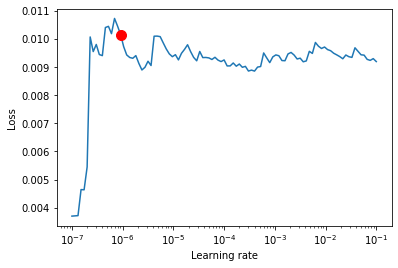

In [36]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [37]:
res.suggestion()

9.120108393559097e-07

In [38]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= res.suggestion(),
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss = RMSE(),#new_tweedieloss(),
    log_interval=20,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 30.5k


In [39]:
#Early Stopping 
MIN_DELTA  = 1e-7
PATIENCE   = 30

#PL Trainer
MAX_EPOCHS = 500

GPUS = 1



# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../../results/models/tft/',
    filename='MODEL_tft-tweedie-loss-epoch_{epoch:02d}-val_loss_{val_loss:.3f}',
    auto_insert_metric_name=False,
    
 )

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    #weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback,checkpoint_callback],
    #log_every_n_steps=10,
    logger=logger,
)
trainer.enforce_positive_output=True


print('holas')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


holas


In [40]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 12.9 K
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Epoch 0:  45%|███████████████████▋                        | 30/67 [00:04<00:05,  7.29it/s, loss=0.0138, v_num=16, train_loss_step=0.00421]
Validation: 0it [00:00, ?it/s]
Epoch 1:  45%|█▊  | 30/67 [00:04<00:05,  7.10it/s, loss=0.01, v_num=16, train_loss_step=0.00275, val_loss=0.0106, train_loss_epoch=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 2:  45%|▍| 30/67 [00:04<00:05,  7.12it/s, loss=0.0112, v_num=16, train_loss_step=0.00745, val_loss=0.0106, train_loss_epoch=0.00986]
Validation: 0it [00:00, ?it/s]
Epoch 3:  45%|▉ | 30/67 [00:04<00:05,  7.13it/s, loss=0.0168, v_num=16, train_loss_step=0.00387, val_loss=0.0106, train_loss_epoch=0.0115]
Validation: 0it [00:00, ?it/s]
Epoch 4:  45%|█▎ | 30/67 [00:04<00:05,  7.00it/s, loss=0.0145, v_num=16, train_loss_step=0.0176, val_loss=0.0106, train_loss_epoch=0.0141]
Validation: 0it [00:00, ?it/s]
Epoch 5:  45%|█▎ | 30/67 [00:04<00:05,  7.13it/s, loss=0.0145, v_num=16, train_loss_step=0.0108, val_loss=0.0106, train_loss_epoch=0.0141]
Validation:

In [43]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)
best_model_name = best_model_path.split('/')[-1]
print('best_model_name = ',best_model_name)

/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/DATATHON-ENTEL-2022---Reto2/results/models/tft/MODEL_tft-tweedie-loss-epoch_21-val_loss_0.011.ckpt
best_model_name =  MODEL_tft-tweedie-loss-epoch_21-val_loss_0.011.ckpt


In [44]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)
criterion = nn.MSELoss()
rmse_val = torch.sqrt(criterion(actuals,val_predictions)).item()
print('rmse_val = ',rmse_val)
#rmse_val =  4.774808883666992

rmse_val =  0.014899672009050846


<AxesSubplot:xlabel='ratio'>

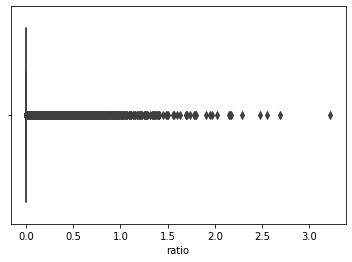

In [45]:
import seaborn as sns
sns.boxplot(data=df_train,x='ratio')

In [46]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

max_prediction_length: 10
max_encoder_length   : 60


In [47]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

0 49


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num
0,MOD_1,PVENT_1,GAM_1,0.000000,0
1,MOD_1,PVENT_1,GAM_1,0.000000,1
2,MOD_1,PVENT_1,GAM_1,0.000000,2
3,MOD_1,PVENT_1,GAM_1,0.000000,3
4,MOD_1,PVENT_1,GAM_1,0.000000,4
...,...,...,...,...,...
2358645,MOD_99,PVENT_99,GAM_3,0.000000,45
2358646,MOD_99,PVENT_99,GAM_3,0.000000,46
2358647,MOD_99,PVENT_99,GAM_3,0.005993,47
2358648,MOD_99,PVENT_99,GAM_3,0.003273,48


In [48]:

last_data = df_train[df_train['date_block_num'].isin([idx  -  max_prediction_length for idx in df_test['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'ratio' not in col]], 
        last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio"]+statistics_columns],
        on = ['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [49]:
last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio"]+statistics_columns]

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio
40,50,MOD_1,PVENT_1,GAM_1,0.361084
41,51,MOD_1,PVENT_1,GAM_1,0.548340
42,52,MOD_1,PVENT_1,GAM_1,0.884277
43,53,MOD_1,PVENT_1,GAM_1,1.017578
44,54,MOD_1,PVENT_1,GAM_1,1.449219
...,...,...,...,...,...
2358645,55,MOD_99,PVENT_99,GAM_3,0.000000
2358646,56,MOD_99,PVENT_99,GAM_3,0.000000
2358647,57,MOD_99,PVENT_99,GAM_3,0.005993
2358648,58,MOD_99,PVENT_99,GAM_3,0.003273


In [52]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)

In [53]:
predictions = pd.DataFrame(new_raw_predictions.numpy()).T
predictions['date_block_num'] = sorted(df_test['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)
df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']].sort_values(['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']).reset_index(drop=True)
df_test2 = df_test.join(predictions['value'])

In [54]:
df_test2.head()

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,value
0,50,MOD_1,PVENT_1,GAM_1,0.0,1.535267e-07
1,51,MOD_1,PVENT_1,GAM_1,0.0,1.987189e-07
2,52,MOD_1,PVENT_1,GAM_1,0.0,1.269469e-07
3,53,MOD_1,PVENT_1,GAM_1,0.0,2.702113e-07
4,54,MOD_1,PVENT_1,GAM_1,0.0,1.720216e-07


In [55]:
import pickle

reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)

In [56]:
#reverse_mapping#

In [57]:
#descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in df_test2.columns:
        df_test2[column] = df_test2[column].map(reverse_mapping[i])
    i+=1

In [58]:
df_test2.head()

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,value
0,50,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,1.535267e-07
1,51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,1.987189e-07
2,52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,1.269469e-07
3,53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,2.702113e-07
4,54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,1.720216e-07


In [59]:

inv_dict_dates = {v: k for k, v in dict_dates.items()}
df_test2['Z_WEEK'] = df_test2['date_block_num'].map(inv_dict_dates)

In [60]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_test2[column] = df_test2[column].astype(str)

In [61]:
df_test2['ID'] = df_test2['Z_MODELO'] + '|' + df_test2['Z_PUNTO_VENTA'] + '|' + df_test2['Z_GAMA'] + '|' + df_test2['Z_WEEK']

In [62]:
df_test2['ratio'] = np.maximum(df_test2['value'],0)
submission = df_test2[['Z_WEEK','ID','ratio']]#.groupby('ID').sum().reset_index()

In [63]:
df_test2.head(10)

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,value,Z_WEEK,ID
0,50,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.535267e-07,1.535267e-07,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
1,51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.987189e-07,1.987189e-07,SEMANA_52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
2,52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.269469e-07,1.269469e-07,SEMANA_53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
3,53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,2.702113e-07,2.702113e-07,SEMANA_54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
4,54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.720216e-07,1.720216e-07,SEMANA_55,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
5,55,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,2.279860e-07,2.279860e-07,SEMANA_56,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
6,56,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.202381e-07,1.202381e-07,SEMANA_57,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
7,57,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.624551e-07,1.624551e-07,SEMANA_58,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
8,58,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.627685e-07,1.627685e-07,SEMANA_59,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
9,59,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,1.550223e-07,1.550223e-07,SEMANA_60,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...


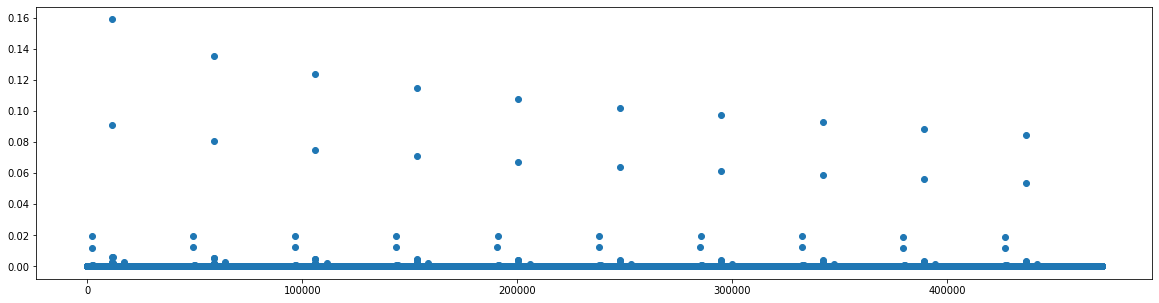

In [64]:
import matplotlib.pyplot as plt

aux = df_test2['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()
# rmse daba ratios muy pequenos de 0 a 0.01
# TWEDDIE P 1.5 daba ratios muy pequenos de 0 a 0.01
# TWEDDIE P 1.01  daba ratios muy pequenos de 0 a 0.14


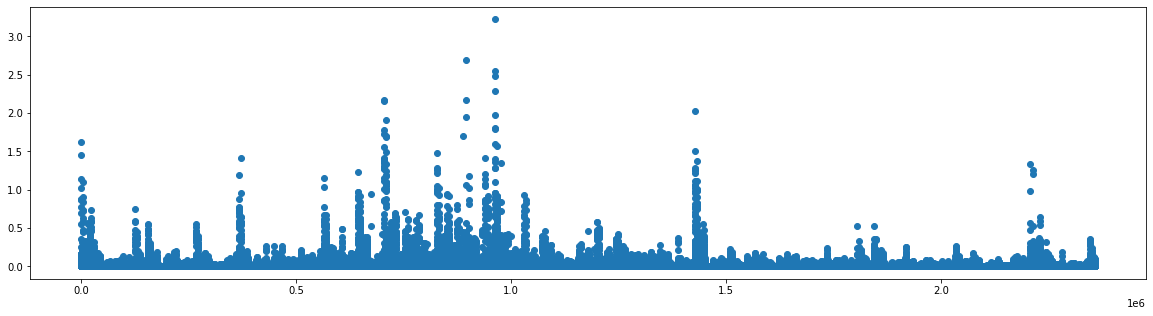

In [65]:
import matplotlib.pyplot as plt

aux = df_train['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [66]:
#submission['Demanda'] = 0.9#submission['value']
import numpy as np
# +'_refencia_best_pred_rmse_'+str(np.round(rms,2))+
submission[['ID', 'ratio']].to_csv('../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_RATIOS.csv', index = False, sep = ',')

In [67]:
submission.head(1)

,Z_WEEK,ID,ratio
0,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,1.535267e-07


In [68]:
submission.head(1)

,Z_WEEK,ID,ratio
0,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,1.535267e-07
